# This notebook reads the FITS File generated by Dsim


In [5]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
import targets
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
import maskLayouts
from smdtLibs import utils, drawUtils, DARCalculator
from astropy.modeling import models, fitting
from Test_InputMihoIshigaki import Test_Inputs
from DistortionUtil import projectTargetXYs, projectTargets2Slits
import DistortionUtil

<IPython.core.display.Javascript object>

In [6]:
try:
    %load_ext nb_black
except Exception as e:
    print("Ignore extension nb_black", e)
    pass

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [7]:
logging.disable()

<IPython.core.display.Javascript object>

## Read the config file and the parameter file

In [8]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)

atRefr = DARCalculator.DARCalculator(
    config.properties["tellatitude"],
    config.properties["referencewavelen"] * 1000,
    615,
    0,
)

<IPython.core.display.Javascript object>

## The mask layout

In [9]:
layout = MaskLayouts["deimos"]
layoutMM = maskLayouts.scaleLayout(layout, utils.AS2MM, 0, -128)
guiderLayout = GuiderFOVs["deimos"]
guiderLayoutMM = maskLayouts.scaleLayout(guiderLayout, utils.AS2MM, 0, -128)

<IPython.core.display.Javascript object>

In [10]:
Test_Inputs.keys()

dict_keys(['CetusIII'])

<IPython.core.display.Javascript object>

# Select Input file

In [11]:
designInfo = Test_Inputs["CetusIII"]

#designInfo = Test_Inputs['dec0Pa75']
FileName, input_RA, input_DEC, fieldPA, haDeg, flag = designInfo


<IPython.core.display.Javascript object>

### Define the coordinates of the center

The center (RA/DEC) is defined in the input target list, first row.

This is different than the pointing coordinates in the FITS file, table maskdesign reference RA/DEC.


In [12]:
cenRA = utils.sexg2Float(input_RA) * 15  # - 22 / 3600
cenDEC = utils.sexg2Float(input_DEC)  # - 5 / 3600

<IPython.core.display.Javascript object>

In [17]:
inFileName = FileName.replace(".fits", ".lst")

<IPython.core.display.Javascript object>

In [18]:
cenRA, cenDEC, FileName

(31.29291666666667,
 -4.2531944444444445,
 '../DeimosExamples/MihoIshigaki/CetusIII.fits')

<IPython.core.display.Javascript object>

In [19]:
mdf = MaskDesignInputFitsFile(FileName)

<IPython.core.display.Javascript object>

In [37]:
mdf.allSlits[mdf.allSlits.inM]

,DesId,ObjectId,dSlitId,TopDist,BotDist,bSlitId,BluId,dSlitId_1,slitX1,slitY1,...,dSlitId_2,DesId_2,SlitName,slitRA,slitDec,slitTyp,slitLen,slitLPA,slitWid,slitWPA
0,1,0,0,11.588,10.384,0,1,0,43.961,104.780,...,0,1,000,31.273465,-4.255742,P,21.972,-52.0,0.7,38.0
1,1,1,1,15.579,4.312,1,1,1,-83.776,59.005,...,1,1,001,31.322486,-4.271825,P,19.891,-52.0,0.7,38.0
2,1,2,2,4.312,6.949,2,1,2,-76.223,215.222,...,2,1,002,31.282627,-4.316108,P,11.261,-52.0,0.7,38.0
3,1,3,3,9.788,11.193,3,1,3,-129.992,27.243,...,3,1,003,31.344012,-4.273185,P,20.981,-52.0,0.7,38.0
4,1,4,4,26.738,9.788,4,1,4,-145.503,17.482,...,4,1,004,31.352693,-4.275200,P,36.526,-52.0,0.7,38.0
5,1,5,5,11.193,4.016,5,1,5,-118.632,25.423,...,5,1,005,31.340371,-4.269503,P,15.209,-52.0,0.7,38.0
6,1,6,6,6.949,13.529,6,1,6,-60.929,194.583,...,6,1,006,31.283861,-4.307132,P,20.478,-52.0,0.7,38.0
7,1,7,7,20.545,5.599,7,1,7,-12.077,182.917,...,7,1,007,31.272473,-4.292667,P,26.144,-52.0,0.7,38.0
8,1,8,8,2.804,20.545,8,1,8,-30.903,78.998,...,8,1,008,31.302219,-4.265733,P,23.349,-52.0,0.7,38.0
9,1,9,9,4.016,2.694,9,1,9,-114.323,162.647,...,9,1,009,31.305978,-4.308863,P,6.710,-52.0,0.7,38.0


<IPython.core.display.Javascript object>

In [20]:
tlist = TargetList(inFileName, config=config)
tlist.markInside()

<IPython.core.display.Javascript object>

In [21]:
pntCenRa, pntCenDec, paDeg = mdf.getPNTCenter()
raHs, decs = np.array([pntCenRa / 15.0, cenRA / 15.0]), np.array([pntCenDec, cenDEC])

censX, censY = tlist._calcTelTargetCoords(
    tlist.telRaRad, tlist.telDecRad, raHs, decs, tlist.positionAngle
)
censX1 = censX * utils.AS2MM
censY1 = censY * utils.AS2MM

#  censX/censY projected positions of the array raHs/decs in the focal plane
labels = "Pointing", "CenerLine"
print(f"{' ':<12s} {'X':>5s}mm, {'Y':>5s}mm")
for lb, cx, cy in zip(labels, censX, censY):
    print(f"{lb:<12s} {cx:7.2f}, {cy:7.2f}")

print(f"pnt center {pntCenRa:.3f}, {pntCenDec:.3f}")

                 Xmm,     Ymm
Pointing     367313.20, -2629451.66
CenerLine    520587.53, -2532906.87
pnt center 31.342, -4.189


<IPython.core.display.Javascript object>

In [22]:
math.degrees(tlist.telRaRad), cenRA

(31.339218782787732, 31.29291666666667)

<IPython.core.display.Javascript object>

## Get shortcuts for inside targets, alignment boxes, guider boxes

In [23]:
allTargetsOrg = tlist.targets

print("len allTargets", len(allTargetsOrg))
allTargets = allTargetsOrg[allTargetsOrg.selected > 0]
# allTargets = allTargetsOrg
print("len allTargets (selected > 0)", len(allTargets))

inTargets = allTargets[allTargets.inMask > 0]
print("In mask", len(inTargets))

inSelectedTargets = inTargets[inTargets.pcode > 0]
print("Targets", len(inSelectedTargets))

inAlignBoxes = inTargets[inTargets.pcode == -2]
guideBoxes = inTargets[inTargets.pcode == -1]
print("Align boxes", len(inAlignBoxes), "guide boxes", len(guideBoxes))

len allTargets 318
len allTargets (selected > 0) 52
In mask 47
Targets 38
Align boxes 7 guide boxes 2


<IPython.core.display.Javascript object>

### Plot the mask layout and the targets inside

<IPython.core.display.Javascript object>


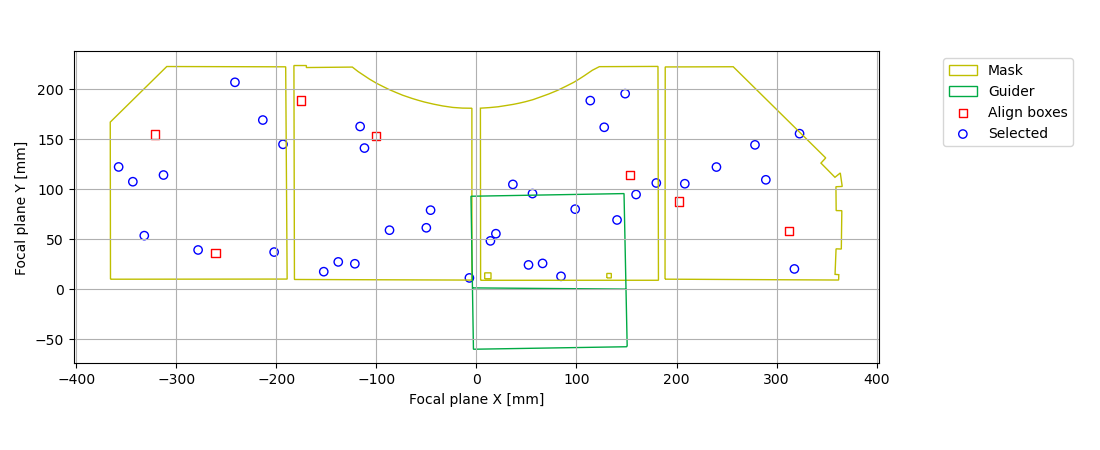

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(11, 4.5))
plt.gca().set_aspect("equal")

p1 = drawUtils.drawPatch(plt.gca(), layoutMM, fc="None", ec="y")
p1.set_label("Mask")
p2 = drawUtils.drawPatch(plt.gca(), guiderLayoutMM, fc="None", ec="#00aa44")
p2.set_label("Guider")

plt.scatter(
    inAlignBoxes.xmm,
    inAlignBoxes.ymm,
    fc="None",
    ec="r",
    marker="s",
    label="Align boxes",
)


plt.scatter(
    inSelectedTargets.xmm,
    inSelectedTargets.ymm,
    fc="None",
    ec="b",
    marker="o",
    label="Selected",
)


# plt.scatter(
#    xarcs1, yarcs1, fc="None", ec="y", marker="x", label="Method2",
# )

plt.xlabel("Focal plane X [mm]")
plt.ylabel("Focal plane Y [mm]")

plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.grid()
plt.tight_layout()

## The Slits coordinates (from DSIM FITS file)
### Conversion from mm to arcsec

The slits coordinates are given in mm, so we convert them to arcsec.

In [25]:

# targetOnSlitX/Y = position of targets
# slitXYs = the four corners of the slits
# DSIM slits coordinates
dsimTargets = mdf.allSlits
# selDsimTargets = dsimTargets[dsimTargets.selected > 0]
inDsimTargets = dsimTargets[dsimTargets.slitTyp == "P"]
inDsimTargets = inDsimTargets[inDsimTargets.dSlitId > 0]
# inDsimTargets.raHour
print (len(dsimTargets), len(inDsimTargets))
dsimXs, dsimYs, slitXYs = projectTargetXYs(inDsimTargets, scale=1)


49 41


<IPython.core.display.Javascript object>

In [26]:
128.8 * 1.37

176.45600000000002

<IPython.core.display.Javascript object>

## Calculate slits coordinates using target coordinates, no distortion compensation


In [27]:
# pfx, pfy = tlist.getDistortionFunctions()
# calcXs, calcYs, wantSlitXYs = projectTargets2Slits(inSelectedTargets, config, 0, 0)
calcXs, calcYs = inSelectedTargets.xmm[1:], inSelectedTargets.ymm[1:]
# calcXs, calcYs = inSelectedTargets.xarcs[1:], inSelectedTargets.yarcs[1:]

<IPython.core.display.Javascript object>

In [28]:
inBoth = calcXs.index.join(dsimXs.index, how="inner")
calcXs, calcYs, dsimXs, dsimYs = [x[inBoth] for x in (calcXs, calcYs, dsimXs, dsimYs)]

<IPython.core.display.Javascript object>

## Compare DSIM slits coordinates and calculated slits coordinates

### Plot the slits and the mask in arcsec

<IPython.core.display.Javascript object>


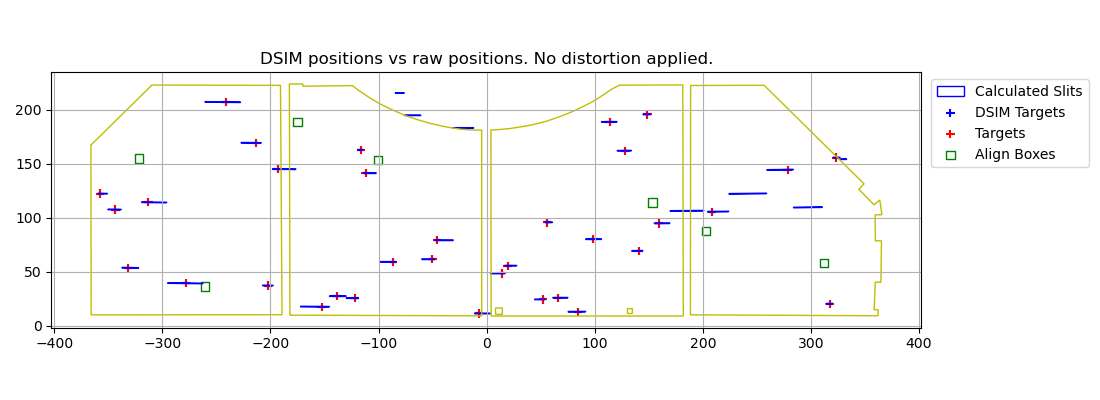

<IPython.core.display.Javascript object>

In [29]:
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")

plt.title("DSIM positions vs raw positions. No distortion applied.")

# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(dsimXs, dsimYs, fc="None", ec="b", marker="+", label="DSIM Targets")


# Plot the calculated slit position
# p1 = drawUtils.drawPatch(plt.gca(), wantSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    calcXs, calcYs, fc="None", ec="r", marker="+", label="Targets",
)

# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layoutMM, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    inAlignBoxes.xmm,
    inAlignBoxes.ymm,
    fc="None",
    ec="g",
    marker="s",
    label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
# plt.plot(xarcs1, yarcs1, "^", label="alternative")
plt.grid()
plt.tight_layout()

## Calculate field projection
### How to match DSIM coordinates?

In [30]:
#
# Calculate the differences in X and Y
#
# dsimXs, dsimYs, calcXs, calcYs = intersectionX(dsimXs, dsimYs, calcXs, calcYs)

dx = dsimXs - calcXs  # [1:]
dy = dsimYs - calcYs  # [1:]

print("mean df", np.median(dx), np.median(dy))
print(len(dsimXs), len(calcXs), len(dx))


mean df 0.00365118155455324 0.005288638869949125
34 34 34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


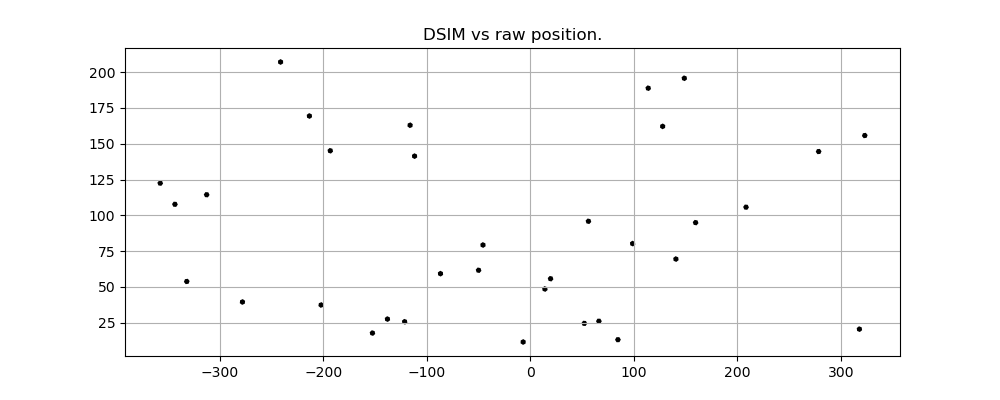

<IPython.core.display.Javascript object>

In [31]:
#
# Plot the difference between projected and original
#
plt.figure(figsize=(10, 4))
plt.title("DSIM vs raw position.")
plt.gca().quiver(
    calcXs, calcYs, dx, dy, scale=0.01, scale_units="xy", headwidth=0.1, headlength=0.1,
)
plt.grid()

In [32]:
#
# Fit the 4th deg 2D polynomial function to map from original to calculated.
#
newFit = False

if newFit:
    pdeg = 4
    xModel = models.Polynomial2D(degree=pdeg)
    xfitter = fitting.LinearLSQFitter()
    xfitted = xfitter(xModel, calcXs, calcYs, dsimXs)

    yModel = models.Polynomial2D(degree=pdeg)
    yfitter = fitting.LinearLSQFitter()
    yfitted = yfitter(yModel, calcXs, calcYs, dsimYs)
else:
    xfitted, yfitted = tlist.getDistortionFunctions()

<IPython.core.display.Javascript object>

In [33]:
projectedX = xfitted(calcXs, calcYs)
projectedY = yfitted(calcXs, calcYs)

alignProjX = xfitted(inAlignBoxes.xmm, inAlignBoxes.ymm)
alignProjY = yfitted(inAlignBoxes.xmm, inAlignBoxes.ymm)

slitWidth = config.params.slitwidth[0]
slitHWidth = slitWidth / 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


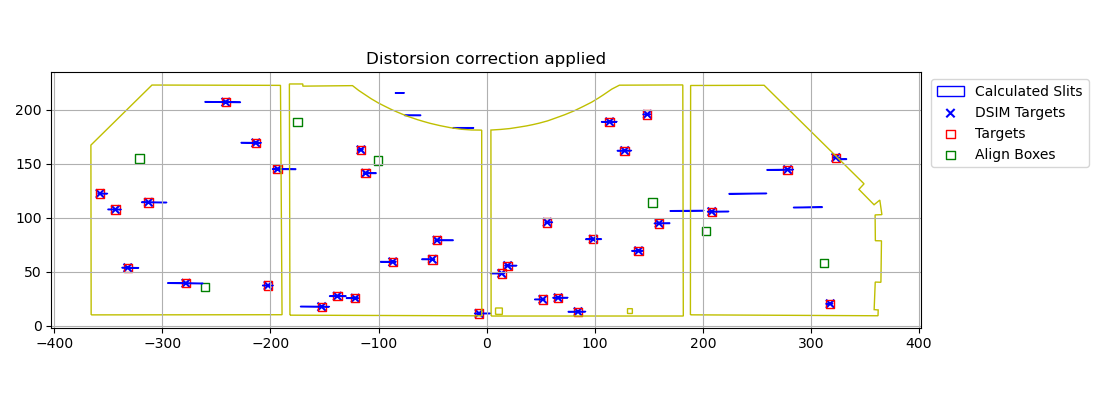

<IPython.core.display.Javascript object>

In [34]:
#
# Plot the coordinates using the fitted model
#
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")
plt.title("Distorsion correction applied")
# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(dsimXs, dsimYs, fc="None", ec="b", marker="x", label="DSIM Targets")

# Plot the calculated slit position
# p1 = drawUtils.drawPatch(plt.gca(), projSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    projectedX, projectedY, fc="None", ec="r", marker="s", label="Targets",
)

# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layoutMM, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    alignProjX, alignProjY, fc="None", ec="g", marker="s", label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


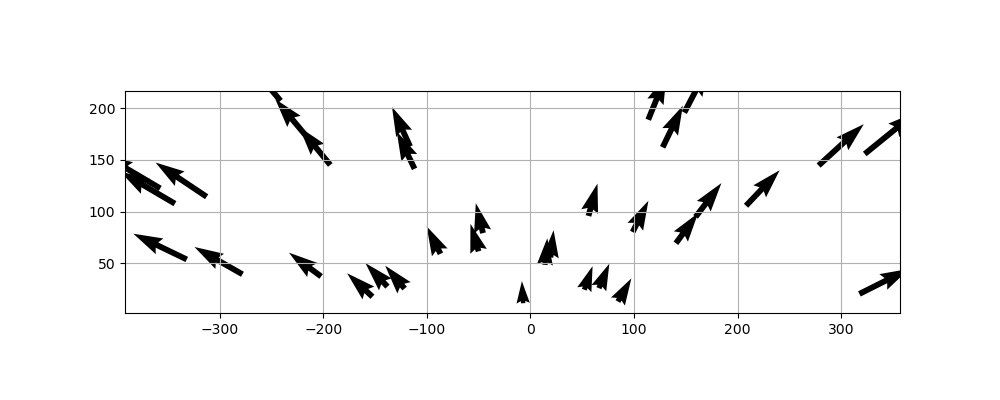

<IPython.core.display.Javascript object>

In [35]:
plt.figure(figsize=(10, 4))

plt.gca().set_aspect("equal")
dx = dsimXs - projectedX  # [1:]
dy = dsimYs - projectedY  # [1:]
plt.gca().quiver(
    projectedX,
    projectedY,
    dx,
    dy,
    # scale=0.00005,
    # scale_units="x",
    # headwidth=4,
    # headlength=5,
)
plt.grid()

<IPython.core.display.Javascript object>


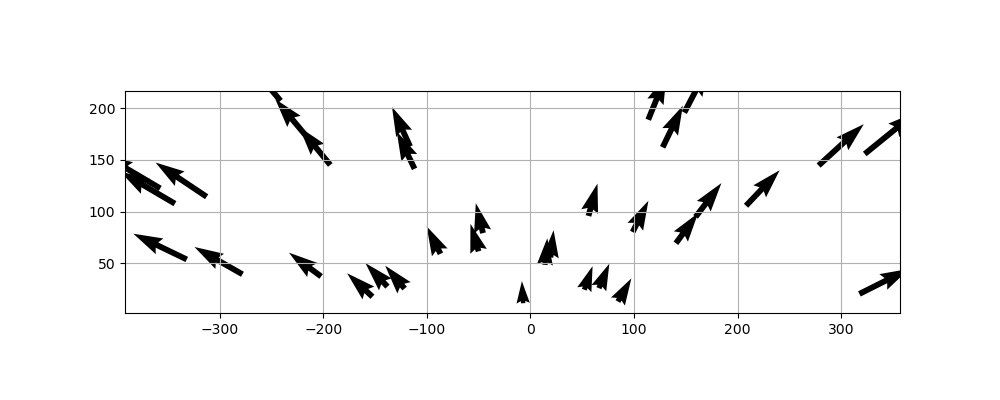

<IPython.core.display.Javascript object>

In [36]:
plt.figure(figsize=(10, 4))

plt.gca().set_aspect("equal")
dx = dsimXs - projectedX  # [1:]
dy = dsimYs - projectedY  # [1:]
plt.gca().quiver(
    projectedX,
    projectedY,
    dx,
    dy,
    # scale=0.00005,
    # scale_units="x",
    # headwidth=4,
    # headlength=5,
)
plt.grid()